In [1]:
import numpy as np
import pandas as pd
import h5py
import matplotlib.pyplot as plt
from joblib import dump, load

import sklearn
import tensorflow as tf
from tensorflow import keras

print ( "sklearn: {}".format(sklearn.__version__) )
print ( "tensorflow: {}".format(tf.__version__) )

2025-05-31 23:07:42.810993: I tensorflow/core/util/port.cc:153] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2025-05-31 23:07:42.873601: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 AVX512F AVX512_VNNI FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


sklearn: 1.5.1
tensorflow: 2.18.0


In [2]:
gpus = tf.config.experimental.list_physical_devices('GPU')
for gpu in gpus:
    tf.config.experimental.set_memory_growth(gpu, True)
if gpus:
    tf.config.experimental.set_visible_devices(gpus[0], 'GPU')

print ( gpus )

[]


In [3]:
train_model = True
save_model = True

model_path = ""
scaler_path = ""
if not train_model:
    model_path = "keras_model.keras"
    scaler_path = "standard_scaler.joblib"

In [4]:
(X_train_full, y_train_full), (X_test, y_test) = keras.datasets.fashion_mnist.load_data()
X_train_full = X_train_full / 255.0
X_test = X_test / 255.0
X_valid, X_train = X_train_full[:10000], X_train_full[10000:]
y_valid, y_train = y_train_full[:10000], y_train_full[10000:]

tf.random.set_seed(42)
np.random.seed(42)

print ( X_train.shape )
print ( X_valid.shape )
print ( X_test.shape )

(50000, 28, 28)
(10000, 28, 28)
(10000, 28, 28)


In [5]:
X_train = X_train.reshape( (len(X_train),28,28,1) )
print( X_train.shape )
X_valid = X_valid.reshape( (len(X_valid),28,28,1) )
print( X_valid.shape )
X_test = X_test.reshape( (len(X_test),28,28,1) )
print( X_test.shape )

X_mean = X_train.mean( axis=0 )
X_std = X_train.std( axis=0 )
X_train_scaled = ( X_train - X_mean ) / X_std
X_valid_scaled = ( X_valid - X_mean ) / X_std
X_test_scaled  = ( X_test - X_mean ) / X_std
X_train_scaled[10]

(50000, 28, 28, 1)
(10000, 28, 28, 1)
(10000, 28, 28, 1)


array([[[-0.00714939],
        [-0.02259701],
        [-0.04749068],
        [-0.04039468],
        [-0.05683006],
        [-0.07010959],
        [-0.09760359],
        [-0.15513164],
        [-0.23893762],
        [-0.37952352],
        [-0.57053077],
        [-0.694674  ],
        [-0.75900494],
        [-0.74973597],
        [-0.74937949],
        [-0.7751858 ],
        [-0.75745513],
        [-0.64652364],
        [-0.50360013],
        [-0.31979054],
        [-0.20224307],
        [-0.13951541],
        [-0.10889008],
        [-0.09206532],
        [-0.06849855],
        [-0.0507646 ],
        [-0.03324326],
        [-0.01443135]],

       [[-0.01230748],
        [-0.0168835 ],
        [-0.03319486],
        [-0.05559106],
        [-0.07714261],
        [-0.13124202],
        [-0.24326328],
        [-0.36492659],
        [-0.48893735],
        [-0.6445122 ],
        [-0.8337121 ],
        [-1.00353902],
        [-1.09301419],
        [-1.0837614 ],
        [-1.06800491],
        [

In [6]:
print ( y_train )

[8 7 6 ... 3 0 5]


In [7]:
import keras.utils

number_of_classes = 10
y_train_cat = keras.utils.to_categorical(y_train, number_of_classes)
y_valid_cat = keras.utils.to_categorical(y_valid, number_of_classes)
y_test_cat = keras.utils.to_categorical(y_test, number_of_classes)

idx=600
y_train[idx], y_train_cat[idx]

(4, array([0., 0., 0., 0., 1., 0., 0., 0., 0., 0.]))

4 [0. 0. 0. 0. 1. 0. 0. 0. 0. 0.] Coat


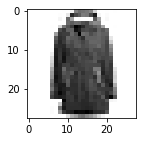

In [8]:
class_names = ["T-shirt/top", "Trouser", "Pullover", "Dress", "Coat",
               "Sandal", "Shirt", "Sneaker", "Bag", "Ankle boot"]

# print ( y_valid[ idx ], y_valid_cat[ idx ], class_names[ y_valid[ idx ] ] )
# print ( X_valid_scaled[ idx ] )
print ( y_train[ idx ], y_train_cat[ idx ], class_names[ y_train[ idx ] ] )

fig = plt.figure( figsize=(2,2) )
plt.imshow( X_train[ idx ], cmap='binary' )

In [9]:
from keras.models import Sequential
from keras.layers import Dense, Dropout, Activation, Flatten
from keras.layers import BatchNormalization
from keras.layers import Conv2D, MaxPooling2D, ZeroPadding2D, GlobalAveragePooling2D

class HyperModel:
    def __init__(self, input_shape, learning_rate):
        self.input_shape = input_shape
        self.learning_rate = learning_rate

    def build(self, dropout):

        input_shape = self.input_shape
        learning_rate = self.learning_rate

        print( "Building model with:" )
        print( "Input shape: {}".format(input_shape) )
        print( "Learning rate: {}".format(learning_rate) )
        print( "Dropout rate: {}".format(dropout) )

        model = Sequential()

        model.add( Conv2D( 32, (3, 3), input_shape=input_shape ) )
        model.add( Activation('relu') )
        BatchNormalization( axis=-1 )
        model.add( Conv2D( 32, (3, 3) ) )
        model.add( Activation('relu') )
        model.add( MaxPooling2D( pool_size=(2,2) ) )

        BatchNormalization( axis=-1 )
        model.add( Conv2D( 64, (3, 3) ) )
        model.add( Activation('relu') )
        BatchNormalization( axis=-1 )
        model.add( Conv2D( 64, (3, 3) ) )
        model.add( Activation('relu') )
        model.add( MaxPooling2D( pool_size=(2,2) ) )

        model.add(Flatten())
        # Fully connected layer

        BatchNormalization()
        model.add( Dense( 512 ) )
        model.add( Activation('relu') )
        BatchNormalization()
        model.add( Dropout( dropout ) )
        model.add( Dense( 10 ) )

        # model.add(Convolution2D(10,3,3, border_mode='same'))
        # model.add(GlobalAveragePooling2D())
        model.add(Activation('softmax'))

        optimizer = keras.optimizers.Adam( learning_rate=learning_rate )
        model.compile(loss='categorical_crossentropy', optimizer=optimizer, metrics=['accuracy'])
        # model.compile(loss='sparse_categorical_crossentropy', optimizer=optimizer, metrics=['accuracy'])

        return model

def build_model(input_shape, learning_rate=5e-4, dropout=0.20 ):
    hm_ = HyperModel( input_shape=input_shape, learning_rate=learning_rate )
    return hm_.build( dropout )

In [10]:
class ExponentialDecayLR:
    def __init__( self, lr0, s ):
        self.lr0 = lr0
        self.s = s
    def __call__( self, epoch ):
        return self.lr0 * 0.1**( epoch / self.s )

exponential_decay_ = ExponentialDecayLR( lr0=1e-2, s=10 )

In [11]:
import os

def get_run_logdir(log_dir):
    import time
    run_id = time.strftime("run_%Y_%m_%d-%H_%M_%S")
    return os.path.join(log_dir, run_id)

def callbacks(patience=5, lr_scheduler_fn=None, log_dir=None):
    callbacks_ = []
    # Early stopping
    if patience > 0:
        early_stopping_cb_ = keras.callbacks.EarlyStopping( patience=patience, restore_best_weights=True )
        callbacks_.append( early_stopping_cb_ )

    # Learning rate exponential decay
    if lr_scheduler_fn:
        lr_scheduler_cb_ = keras.callbacks.LearningRateScheduler( lr_scheduler_fn )
        callbacks_.append( lr_scheduler_cb_ )

    # TensorBoard
    if log_dir:
        run_logdir = get_run_logdir(log_dir)
        print ( "Log dir: {}".format(run_logdir) )
        tensorboard_cb_ = keras.callbacks.TensorBoard( run_logdir )
        callbacks_.append( tensorboard_cb_ )

    return callbacks_


In [12]:
# Trainign batch size
batch_size = 32
# Number of training epochs
epochs = 20
# Learning rate
lr = 5e-4
callbacks_ = callbacks( patience=5, lr_scheduler_fn=exponential_decay_ )

model = build_model( (28,28,1), learning_rate=lr, dropout=0.10 )
model.summary()

Building model with:
Input shape: (28, 28, 1)
Learning rate: 0.0005
Dropout rate: 0.1


/cvmfs/sft.cern.ch/lcg/views/LCG_107_swan/x86_64-el9-gcc13-opt/lib/python3.11/site-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 26, 26, 32)     │           320 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation (Activation)         │ (None, 26, 26, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 24, 24, 32)     │         9,248 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_1 (Activation)       │ (None, 24, 24, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 12, 12, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 10, 10, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_2 (Activation)       │ (None, 10, 10, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_3 (Conv2D)               │ (None, 8, 8, 64)       │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_3 (Activation)       │ (None, 8, 8, 64)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 4, 4, 64)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 1024)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 512)            │       524,800 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_4 (Activation)       │ (None, 512)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 512)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 10)             │         5,130 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_5 (Activation)       │ (None, 10)             │             0 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 594,922 (2.27 MB)

 Trainable params: 594,922 (2.27 MB)

 Non-trainable params: 0 (0.00 B)

In [13]:
# history = model.fit( X_train_scaled, y_train, batch_size=batch_size, epochs=epochs, validation_data=(X_valid_scaled, y_valid), callbacks=callbacks_ )
history = model.fit( X_train_scaled, y_train_cat, batch_size=batch_size, epochs=epochs, validation_data=(X_valid_scaled, y_valid_cat), callbacks=callbacks_ )

Epoch 1/20
1563/1563 ━━━━━━━━━━━━━━━━━━━━ 45s 27ms/step - accuracy: 0.7175 - loss: 0.7920 - val_accuracy: 0.8048 - val_loss: 0.5601 - learning_rate: 0.0100
Epoch 2/20
1563/1563 ━━━━━━━━━━━━━━━━━━━━ 41s 26ms/step - accuracy: 0.8170 - loss: 0.5091 - val_accuracy: 0.8298 - val_loss: 0.4588 - learning_rate: 0.0079
Epoch 3/20
1563/1563 ━━━━━━━━━━━━━━━━━━━━ 41s 26ms/step - accuracy: 0.8334 - loss: 0.4518 - val_accuracy: 0.8335 - val_loss: 0.4539 - learning_rate: 0.0063
Epoch 4/20
1563/1563 ━━━━━━━━━━━━━━━━━━━━ 41s 26ms/step - accuracy: 0.8497 - loss: 0.4027 - val_accuracy: 0.8540 - val_loss: 0.4052 - learning_rate: 0.0050
Epoch 5/20
1563/1563 ━━━━━━━━━━━━━━━━━━━━ 42s 27ms/step - accuracy: 0.8594 - loss: 0.3770 - val_accuracy: 0.8584 - val_loss: 0.3820 - learning_rate: 0.0040
Epoch 6/20
1563/1563 ━━━━━━━━━━━━━━━━━━━━ 42s 27ms/step - accuracy: 0.8714 - loss: 0.3441 - val_accuracy: 0.8632 - val_loss: 0.3895 - learning_rate: 0.0032
Epoch 7/20
1563/1563 ━━━━━━━━━━━━━━━━━━━━ 41s 26ms/step - accura

In [14]:
# score = model.evaluate( X_valid_scaled, y_valid )
score = model.evaluate( X_valid_scaled, y_valid_cat )
print ( score )

313/313 ━━━━━━━━━━━━━━━━━━━━ 2s 7ms/step - accuracy: 0.8789 - loss: 0.3449
[0.3518740236759186, 0.8755999803543091]


In [15]:
# score = model.evaluate( X_test_scaled, y_test )
score = model.evaluate( X_test_scaled, y_test_cat )
print ( score )

313/313 ━━━━━━━━━━━━━━━━━━━━ 2s 7ms/step - accuracy: 0.8734 - loss: 0.3528
[0.3568876087665558, 0.8726999759674072]


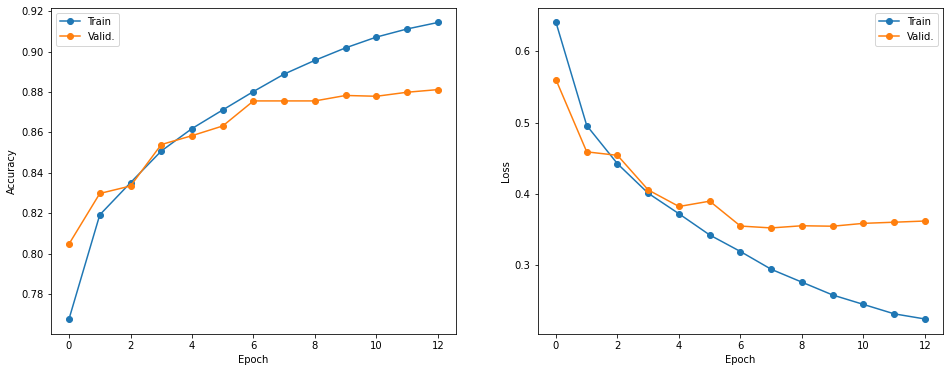

In [16]:
fig, axes = plt.subplots( 1, 2, figsize=(16,6) )
axes[0].plot( history.epoch, history.history['accuracy'], 'o-', label="Train" )
axes[0].plot( history.epoch, history.history['val_accuracy'], 'o-', label="Valid." )
axes[1].plot( history.epoch, history.history['loss'], 'o-', label="Train" )
axes[1].plot( history.epoch, history.history['val_loss'], 'o-', label="Valid." )
axes[0].set_xlabel('Epoch')
axes[0].set_ylabel('Accuracy')
axes[0].legend( loc='best' )
axes[1].set_xlabel('Epoch')
axes[1].set_ylabel('Loss')
axes[1].legend( loc='best' )

In [17]:
y_test_proba = model.predict( X_test_scaled )
print ( y_test_proba )
y_test_pred = np.argmax( y_test_proba, axis=-1 )
print ( y_test_pred )

313/313 ━━━━━━━━━━━━━━━━━━━━ 3s 7ms/step
[[5.8163353e-11 1.0683808e-10 2.1169993e-13 ... 5.4847519e-04
  2.7307284e-12 9.9945134e-01]
 [3.5823687e-04 2.4568267e-10 9.7668171e-01 ... 1.1142591e-12
  1.3565858e-06 1.0064582e-10]
 [7.8821776e-18 1.0000000e+00 1.7946921e-26 ... 3.2392375e-32
  3.7666373e-24 2.2322040e-24]
 ...
 [1.8599061e-10 2.4236716e-13 6.9382396e-11 ... 5.3402608e-14
  1.0000000e+00 4.3221491e-15]
 [1.3276580e-12 1.0000000e+00 2.5597693e-18 ... 1.1287932e-19
  4.1345061e-17 1.6285400e-12]
 [3.0474766e-05 2.9118477e-08 7.3762618e-07 ... 7.2584632e-03
  1.7159238e-02 6.6066646e-06]]
[9 2 1 ... 8 1 5]


In [18]:
accuracy = np.sum( y_test_pred == y_test ) / y_test.size
print ( "Accuracy = {}".format( accuracy ) )

Accuracy = 0.8727


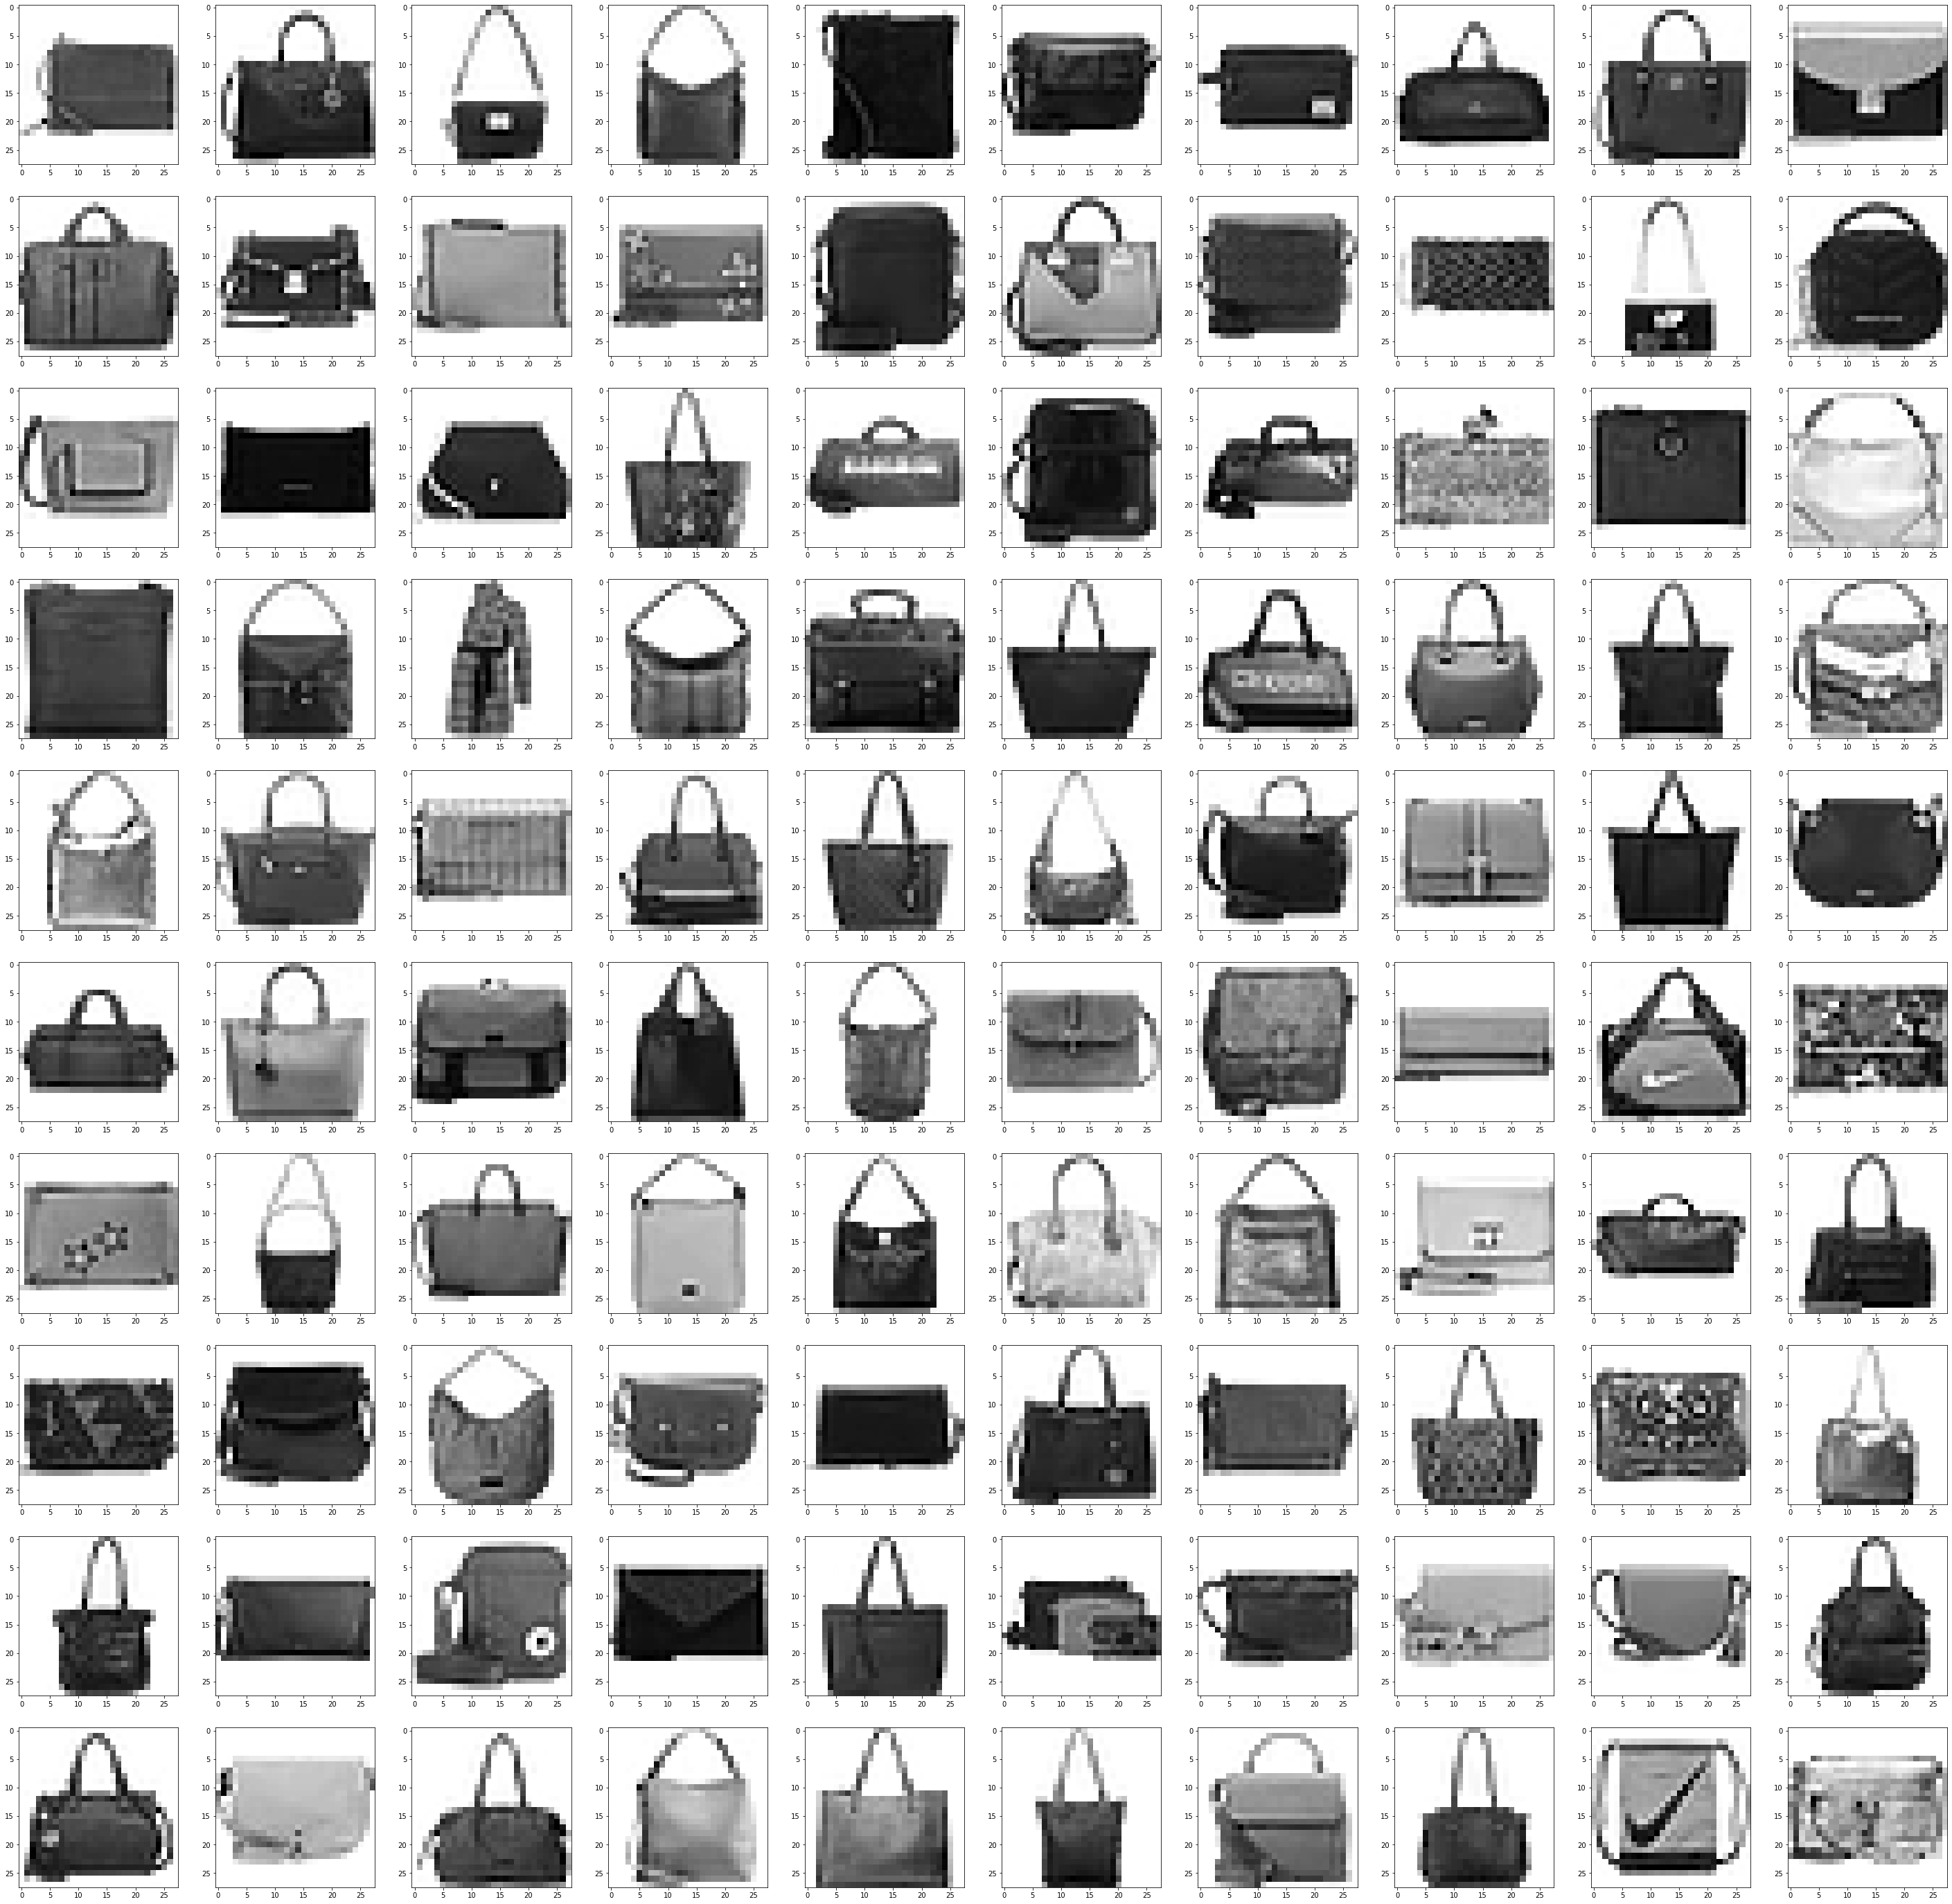

In [19]:
def plot_images( X, n, start = 0 ):
    n_per_row_ = 10
    n_rows_ = int( ( n / n_per_row_  ) if ( n % n_per_row_ ) == 0 else ( ( n // n_per_row_ ) + 1 ) )
    size_ = 5
    fig_, axes_ = plt.subplots( n_rows_, n_per_row_, figsize=( n_per_row_ * size_ , n_rows_ * size_ ) )
    idx_row_, idx_col_ = 0, 0
    for idx__ in range( n ):
        if idx__ >= len( X ): break

        ax_ = axes_[ idx_row_, idx_col_ ]
        ax_.imshow( X[ start+idx__ ], cmap='binary' )
        idx_col_ += 1
        if idx_col_ % n_per_row_ == 0:
            idx_row_ += 1
            idx_col_  = 0

# msk_pred_Sneaker_ = ( y_test_pred == 7 )
msk_pred_Bag_ = ( y_test_pred == 8 )

# plot_images( X_test[ msk_pred_Sneaker_ ], 100 )
plot_images( X_test[ msk_pred_Bag_ ], 100 )

1273
T-shirt/top (0): 158
Trouser (1): 33
Pullover (2): 199
Dress (3): 129
Coat (4): 153
Sandal (5): 36
Shirt (6): 434
Sneaker (7): 59
Bag (8): 35
Ankle boot (9): 37


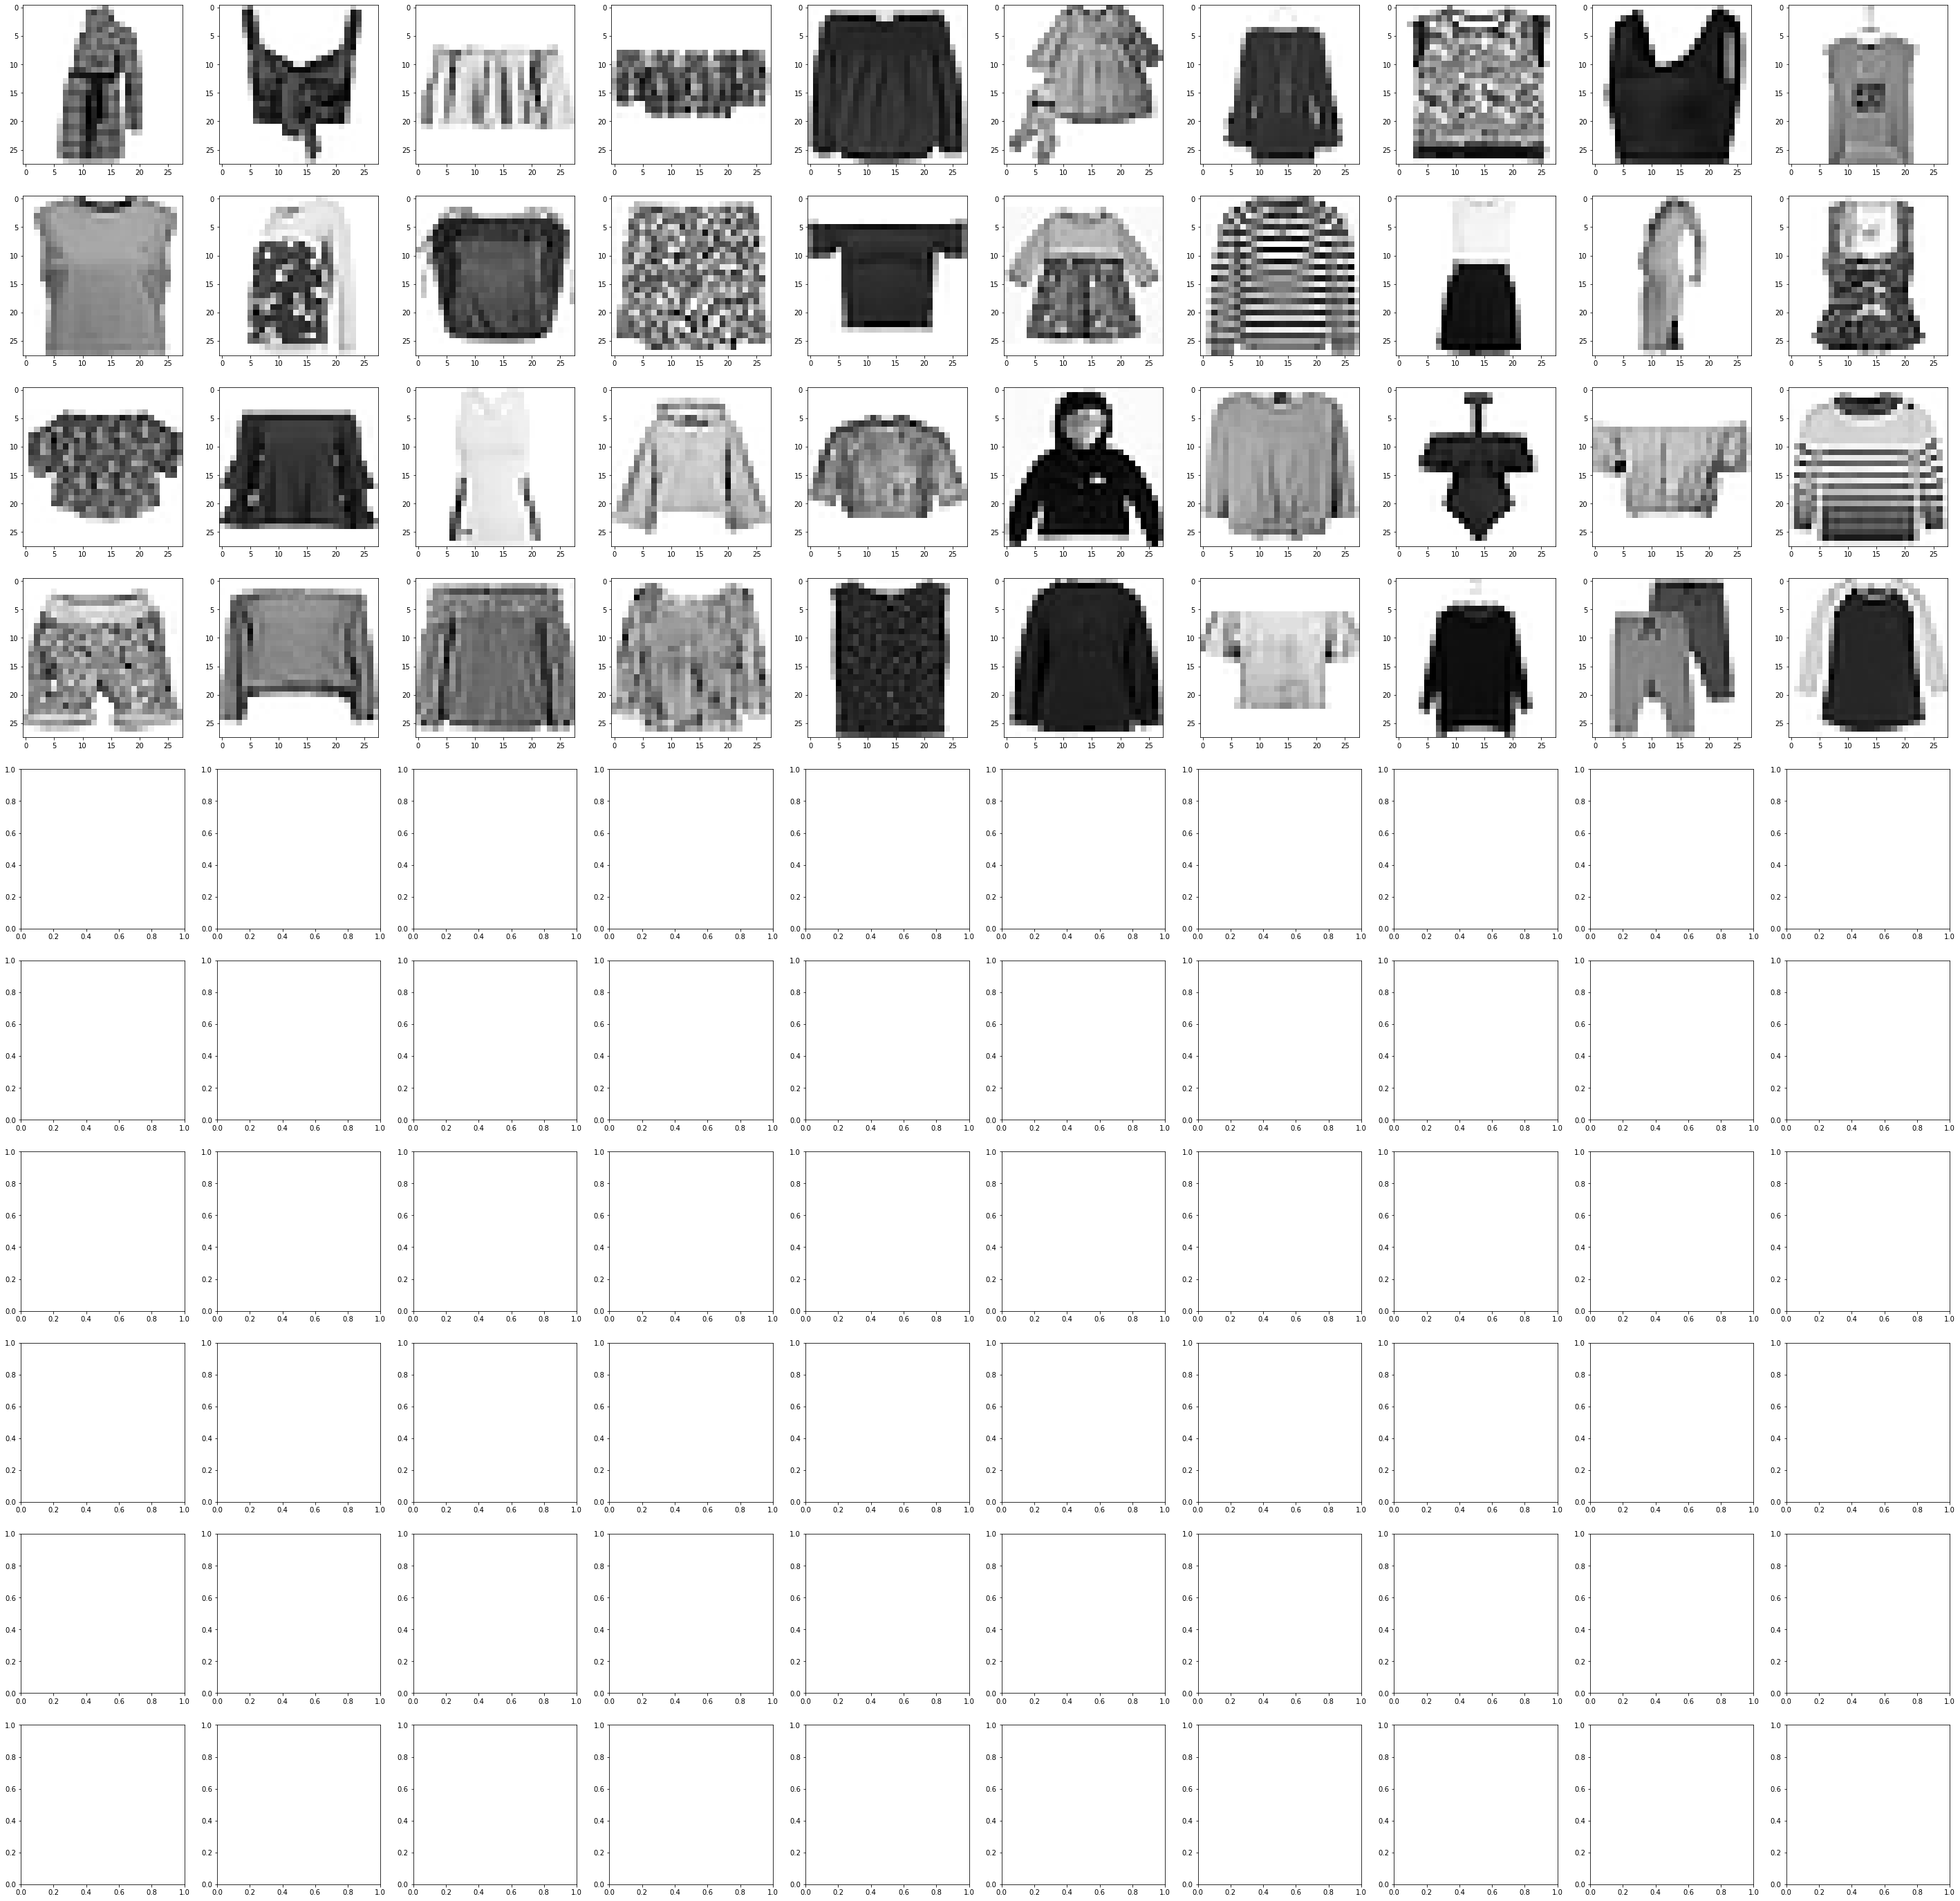

In [20]:
msk_error_ = y_test_pred != y_test
print ( np.sum( msk_error_ ) )
for label_ in range( 10 ):
    msk__ = msk_error_ & ( y_test == label_ )
    print ( "{} ({}): {}".format( class_names[label_], label_, np.sum( msk__ ) ) )

msk_error_pred_Bag_ = msk_error_ & ( y_test_pred == 8 )

# plot_images( X_test[ msk_error_ ], 100 )
plot_images( X_test[ msk_error_pred_Bag_ ], 100 )